In [30]:
# Cell 1: Imports and data loading
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import networkx as nx
from networkx.algorithms import bipartite

In [24]:

# adjust the path if your folder is elsewhere
DATA_DIR = 'ml-latest-small'
ratings = pd.read_csv(f'{DATA_DIR}/ratings.csv')
movies  = pd.read_csv(f'{DATA_DIR}/movies.csv')
tags    = pd.read_csv(f'{DATA_DIR}/tags.csv')
links   = pd.read_csv(f'{DATA_DIR}/links.csv')

# display first few rows to confirm loading
ratings.head(), movies.head(), tags.head(), links.head()

(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    userId  movieId              tag   timestamp
 0       2    60756            funny  1445714994
 1       2    60756  Highly quotable  1445714996
 2       

In [17]:
# 1. Dataset Overview: shapes & missing values
overview = pd.DataFrame({
    'dataset':      ['ratings','movies','tags','links'],
    'rows':         [ratings.shape[0], movies.shape[0], tags.shape[0], links.shape[0]],
    'columns':      [ratings.shape[1], movies.shape[1], tags.shape[1], links.shape[1]],
    'missing_cells':[ratings.isnull().sum().sum(),
                     movies.isnull().sum().sum(),
                     tags.isnull().sum().sum(),
                     links.isnull().sum().sum()]
})
print("=== Dataset Overview ===")
display(overview)

# 2. Cardinality: unique counts
num_users  = ratings['userId'].nunique()
num_movies = movies['movieId'].nunique()
num_tags   = tags['tag'].nunique()
print(f"\n=== Cardinality ===\nUnique users:  {num_users}\nUnique movies: {num_movies}\nUnique tags:   {num_tags}")

# 3. Sparsity: fill‑rate of the user–movie matrix
total_ratings = len(ratings)
possible_pairs = num_users * num_movies
fill_rate = total_ratings / possible_pairs
print(f"\n=== Sparsity ===\nTotal ratings: {total_ratings}\nPossible ratings (users×movies): {possible_pairs}\nFill rate: {fill_rate:.6%}")

=== Dataset Overview ===


,dataset,rows,columns,missing_cells
0,ratings,100836,4,0
1,movies,9742,3,0
2,tags,3683,4,0
3,links,9742,3,8



=== Cardinality ===
Unique users:  610
Unique movies: 9742
Unique tags:   1589

=== Sparsity ===
Total ratings: 100836
Possible ratings (users×movies): 5942620
Fill rate: 1.696827%


=== Rating Descriptive Statistics ===
Mean:   3.502
Median: 3.500
Min:    0.500
25%:    3.000
50%:    3.500
75%:    4.000
Max:    5.000


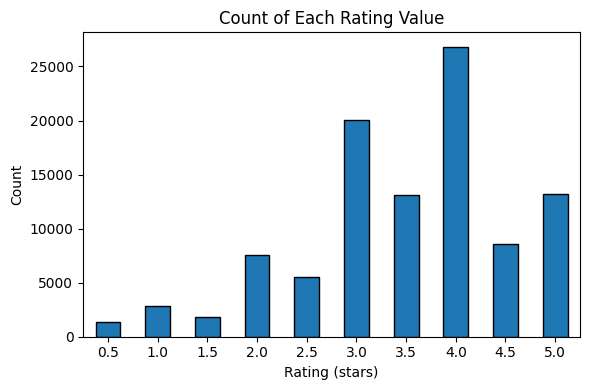

In [18]:
# 2.1 Descriptive statistics
stats = ratings['rating'].describe()
median = ratings['rating'].median()

print("=== Rating Descriptive Statistics ===")
print(f"Mean:   {stats['mean']:.3f}")
print(f"Median: {median:.3f}")
print(f"Min:    {stats['min']:.3f}")
print(f"25%:    {stats['25%']:.3f}")
print(f"50%:    {stats['50%']:.3f}")
print(f"75%:    {stats['75%']:.3f}")
print(f"Max:    {stats['max']:.3f}")

# 2.2 Histogram of star counts
plt.figure(figsize=(6,4))
ratings['rating'] \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar', edgecolor='k')
plt.title('Count of Each Rating Value')
plt.xlabel('Rating (stars)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

=== Ratings per User — Summary ===
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating_count, dtype: float64


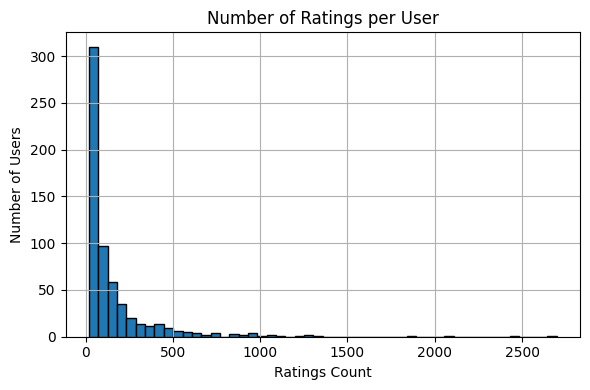


=== Top 10 Power Users ===


,userId,rating_count
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346
5,610,1302
6,68,1260
7,380,1218
8,606,1115
9,288,1055



=== Average Rating per User — Summary ===
count    610.000000
mean       3.657222
std        0.480635
min        1.275000
25%        3.360000
50%        3.694385
75%        3.997500
max        5.000000
Name: avg_rating, dtype: float64


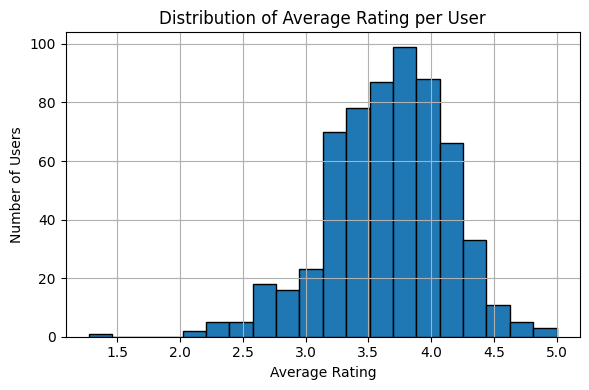

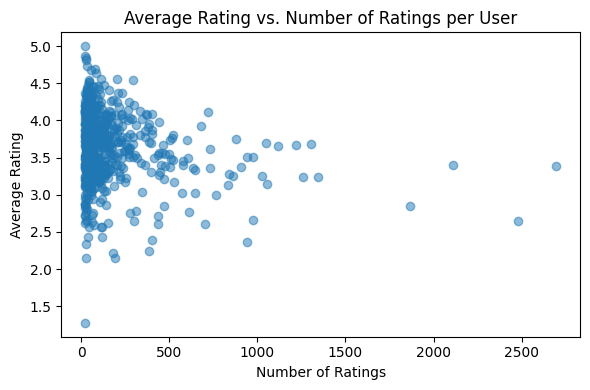

In [19]:
# 3.1 Ratings per user
ratings_per_user = ratings.groupby('userId').size().rename('rating_count')
print("=== Ratings per User — Summary ===")
print(ratings_per_user.describe())

plt.figure(figsize=(6,4))
ratings_per_user.hist(bins=50, edgecolor='k')
plt.title('Number of Ratings per User')
plt.xlabel('Ratings Count')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Identify “power users” (top 10 by number of ratings)
power_users = ratings_per_user.sort_values(ascending=False).head(10).reset_index()
power_users.columns = ['userId', 'rating_count']
print("\n=== Top 10 Power Users ===")
display(power_users)

# 3.2 Average rating per user
avg_rating_per_user = ratings.groupby('userId')['rating'].mean().rename('avg_rating')
print("\n=== Average Rating per User — Summary ===")
print(avg_rating_per_user.describe())

plt.figure(figsize=(6,4))
avg_rating_per_user.hist(bins=20, edgecolor='k')
plt.title('Distribution of Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Relationship between activity and average rating
plt.figure(figsize=(6,4))
plt.scatter(ratings_per_user, avg_rating_per_user, alpha=0.5)
plt.title('Average Rating vs. Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

=== Ratings per Movie — Summary ===
count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating_count, dtype: float64 



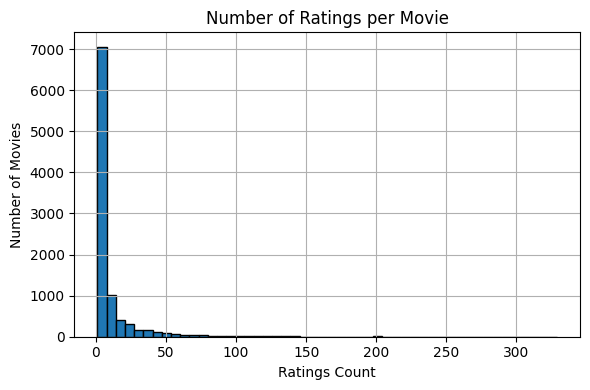

=== Top 10 Most‑Rated Movies ===


,movieId,title,rating_count
0,356,Forrest Gump (1994),329
1,318,"Shawshank Redemption, The (1994)",317
2,296,Pulp Fiction (1994),307
3,593,"Silence of the Lambs, The (1991)",279
4,2571,"Matrix, The (1999)",278
5,260,Star Wars: Episode IV - A New Hope (1977),251
6,480,Jurassic Park (1993),238
7,110,Braveheart (1995),237
8,589,Terminator 2: Judgment Day (1991),224
9,527,Schindler's List (1993),220


=== Cold‑Start Movies (≤ 5 ratings) ===
6456 out of 9742 movies (66.27%) have ≤ 5 ratings


In [20]:
# 4.1 Ratings per movie — summary & distribution
ratings_per_movie = ratings.groupby('movieId').size().rename('rating_count')
print("=== Ratings per Movie — Summary ===")
print(ratings_per_movie.describe(), "\n")

plt.figure(figsize=(6,4))
ratings_per_movie.hist(bins=50, edgecolor='k')
plt.title('Number of Ratings per Movie')
plt.xlabel('Ratings Count')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

# 4.2 Top‑N most‑rated movies
TOP_N = 10
top_n = (ratings_per_movie
         .sort_values(ascending=False)
         .head(TOP_N)
         .reset_index())
top_n = top_n.merge(movies[['movieId','title']], on='movieId')[['movieId','title','rating_count']]
print(f"=== Top {TOP_N} Most‑Rated Movies ===")
display(top_n)

# 4.3 Cold‑start movies: fraction with very few ratings
COLD_THRESHOLD = 5
cold_count = (ratings_per_movie <= COLD_THRESHOLD).sum()
total_movies = movies['movieId'].nunique()
fill = cold_count / total_movies
print(f"=== Cold‑Start Movies (≤ {COLD_THRESHOLD} ratings) ===")
print(f"{cold_count} out of {total_movies} movies ({fill:.2%}) have ≤ {COLD_THRESHOLD} ratings")

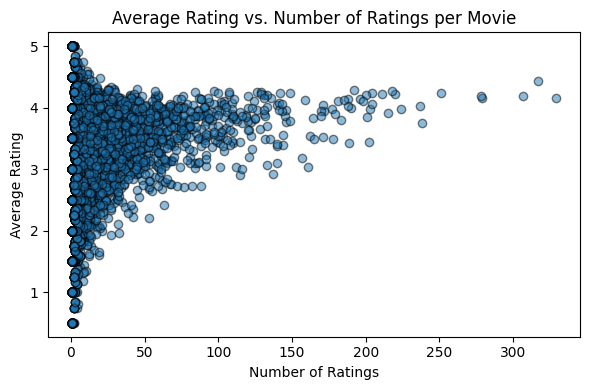

Correlation (rating_count vs. avg_rating): 0.127


In [21]:
# 5.1 Compute number of ratings and average rating per movie
ratings_per_movie = ratings.groupby('movieId').size().rename('rating_count')
avg_rating_per_movie = ratings.groupby('movieId')['rating'].mean().rename('avg_rating')

# 5.2 Scatter plot: popularity vs. average rating
plt.figure(figsize=(6, 4))
plt.scatter(ratings_per_movie, avg_rating_per_movie, alpha=0.5, edgecolor='k')
plt.title('Average Rating vs. Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

# 5.3 Correlation coefficient
corr = ratings_per_movie.corr(avg_rating_per_movie)
print(f"Correlation (rating_count vs. avg_rating): {corr:.3f}")

=== Average Rating Descriptive Statistics ===
count    9724.000000
mean        3.262448
std         0.869874
min         0.500000
25%         2.800000
50%         3.416667
75%         3.911765
max         5.000000
Name: avg_rating, dtype: float64 



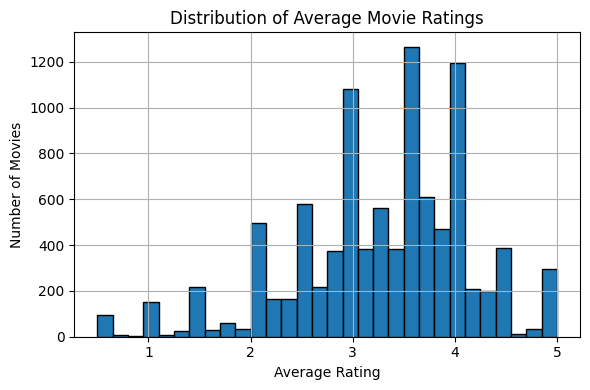

=== Top 10 High‑Rated Outliers (≤10 ratings, avg ≥4.5) ===


,movieId,title,rating_count,avg_rating
0,148,"Awfully Big Adventure, An (1995)",1,5.0
1,467,Live Nude Girls (1995),1,5.0
2,495,In the Realm of the Senses (Ai no corrida) (1976),1,5.0
3,496,What Happened Was... (1994),1,5.0
4,626,"Thin Line Between Love and Hate, A (1996)",1,5.0
5,633,Denise Calls Up (1995),1,5.0
6,876,Supercop 2 (Project S) (Chao ji ji hua) (1993),1,5.0
7,1140,Entertaining Angels: The Dorothy Day Story (1996),1,5.0
8,1310,Hype! (1996),1,5.0
9,1349,Vampire in Venice (Nosferatu a Venezia) (Nosfe...,1,5.0



=== Top 10 Low‑Rated Outliers (≤10 ratings, avg ≤2.5) ===


,movieId,title,rating_count,avg_rating
0,3604,Gypsy (1962),1,0.5
1,3933,"Killer Shrews, The (1959)",1,0.5
2,4051,Horrors of Spider Island (Ein Toter Hing im Ne...,1,0.5
3,4371,Baby Boy (2001),1,0.5
4,4750,3 Ninjas Knuckle Up (1995),1,0.5
5,4775,Glitter (2001),1,0.5
6,5105,Don't Look Now (1973),1,0.5
7,5356,"Giant Spider Invasion, The (1975)",1,0.5
8,5700,The Pumaman (1980),1,0.5
9,5771,My Bloody Valentine (1981),1,0.5


In [22]:
# 6.1 Compute per‑movie stats
ratings_per_movie = ratings.groupby('movieId').size().rename('rating_count')
avg_rating        = ratings.groupby('movieId')['rating'].mean().rename('avg_rating')

movie_stats = pd.concat([ratings_per_movie, avg_rating], axis=1)

# 6.2 Descriptive statistics of average ratings
print("=== Average Rating Descriptive Statistics ===")
print(movie_stats['avg_rating'].describe(), "\n")

# 6.3 Histogram of average ratings
plt.figure(figsize=(6,4))
movie_stats['avg_rating'].hist(bins=30, edgecolor='k')
plt.title('Distribution of Average Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

# 6.4 Identify outliers: movies with extreme avg ratings but few ratings
FEW_THRESH = 10
HIGH_AVG   = 4.5
LOW_AVG    = 2.5

high_outliers = (movie_stats
    .query("rating_count <= @FEW_THRESH and avg_rating >= @HIGH_AVG")
    .sort_values(['avg_rating','rating_count'], ascending=[False, True])
    .head(10)
    .reset_index()
    .merge(movies[['movieId','title']], on='movieId')
    [['movieId','title','rating_count','avg_rating']]
)

low_outliers = (movie_stats
    .query("rating_count <= @FEW_THRESH and avg_rating <= @LOW_AVG")
    .sort_values(['avg_rating','rating_count'], ascending=[True, True])
    .head(10)
    .reset_index()
    .merge(movies[['movieId','title']], on='movieId')
    [['movieId','title','rating_count','avg_rating']]
)

print(f"=== Top {len(high_outliers)} High‑Rated Outliers (≤{FEW_THRESH} ratings, avg ≥{HIGH_AVG}) ===")
display(high_outliers)

print(f"\n=== Top {len(low_outliers)} Low‑Rated Outliers (≤{FEW_THRESH} ratings, avg ≤{LOW_AVG}) ===")
display(low_outliers)

=== Genre Frequency ===


,genre,movie_count
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596
5,Adventure,1263
6,Crime,1199
7,Sci-Fi,980
8,Horror,978
9,Fantasy,779



=== Genre Rating Statistics ===


,genre,avg_rating,rating_count
0,(no genres listed),3.489362,47
1,Action,3.447984,30635
2,Adventure,3.508609,24161
3,Animation,3.629937,6988
4,Children,3.412956,9208
5,Comedy,3.384721,39053
6,Crime,3.658294,16681
7,Documentary,3.797785,1219
8,Drama,3.656184,41928
9,Fantasy,3.491001,11834


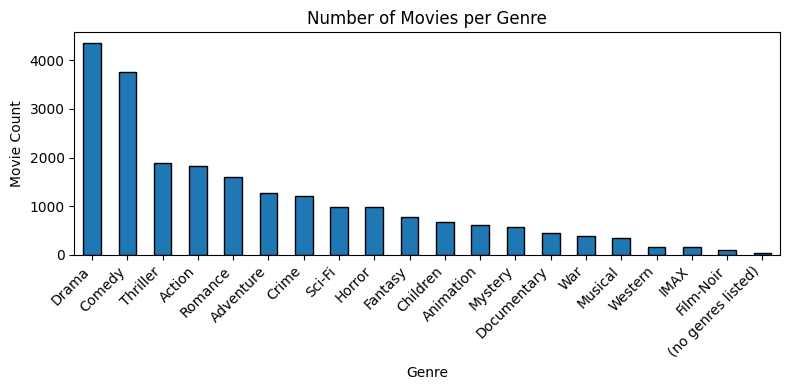

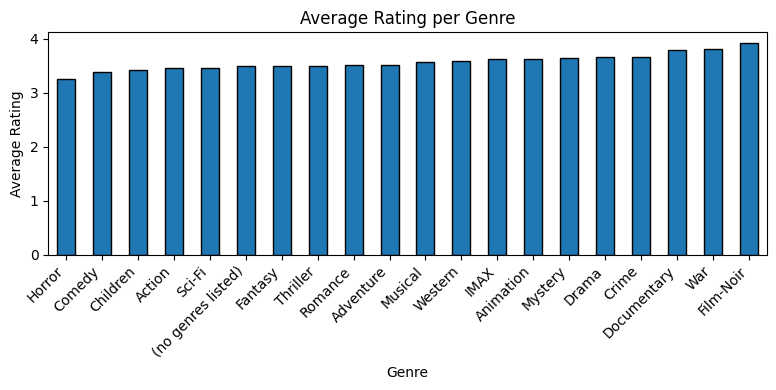

In [23]:
# 7.1 Genre Frequency
movies['genres_list'] = movies['genres'].str.split('|')
genres_exploded = movies.explode('genres_list')
genre_counts = genres_exploded['genres_list'] \
    .value_counts() \
    .reset_index()
genre_counts.columns = ['genre', 'movie_count']

print("=== Genre Frequency ===")
display(genre_counts)

# 7.2 Genre Ratings: average rating and rating count per genre
# Merge ratings with genre info
ratings_with_genres = ratings.merge(
    genres_exploded[['movieId','genres_list']],
    on='movieId'
).rename(columns={'genres_list':'genre'})

# Compute stats per genre
genre_stats = ratings_with_genres.groupby('genre')['rating'] \
    .agg(['mean','count']) \
    .reset_index() \
    .rename(columns={'mean':'avg_rating','count':'rating_count'})

print("\n=== Genre Rating Statistics ===")
display(genre_stats)

# Optional: bar plots
plt.figure(figsize=(8,4))
genre_counts.set_index('genre')['movie_count'].plot(kind='bar', edgecolor='k')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Movie Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
genre_stats.set_index('genre')['avg_rating'].sort_values().plot(
    kind='bar', edgecolor='k'
)
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

=== Top 20 Tags ===


,tag,count
0,In Netflix queue,131
1,atmospheric,36
2,thought-provoking,24
3,superhero,24
4,funny,23
5,surreal,23
6,Disney,23
7,religion,22
8,sci-fi,21
9,quirky,21


/var/folders/6l/dffvttrj3v35nxl93kxx60g40000gn/T/ipykernel_16867/4269265926.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'tag'])


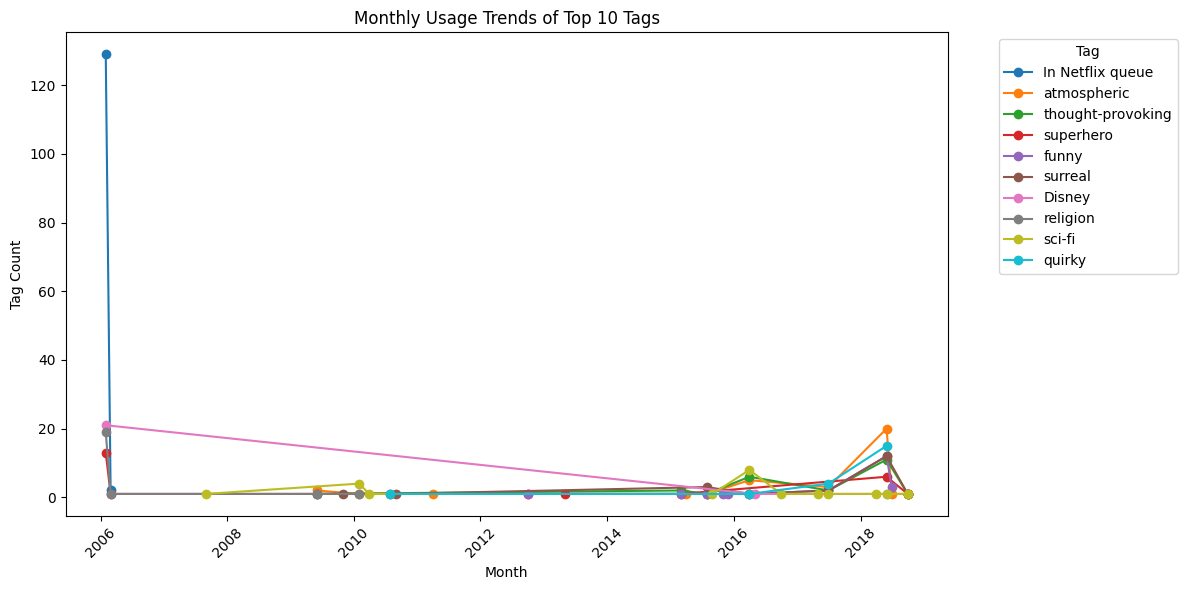

In [25]:
# 8.1 Unique tags & frequencies (top 20)
tag_counts = tags['tag'].value_counts().head(20).reset_index()
tag_counts.columns = ['tag', 'count']
print("=== Top 20 Tags ===")
display(tag_counts)

# 8.2 Tag temporal trends
# Convert timestamp to datetime
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# Compute monthly counts per tag
monthly_tag_counts = (
    tags
    .set_index('timestamp')
    .groupby([pd.Grouper(freq='M'), 'tag'])
    .size()
    .reset_index(name='monthly_count')
)

# Plot trends for top 10 tags
top_tags = tag_counts['tag'].head(10).tolist()

plt.figure(figsize=(12, 6))
for tag in top_tags:
    df_tag = monthly_tag_counts[monthly_tag_counts['tag'] == tag]
    plt.plot(df_tag['timestamp'], df_tag['monthly_count'], marker='o', label=tag)

plt.legend(title='Tag', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Month')
plt.ylabel('Tag Count')
plt.title('Monthly Usage Trends of Top 10 Tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/6l/dffvttrj3v35nxl93kxx60g40000gn/T/ipykernel_16867/4056393423.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = ratings.set_index('timestamp')['rating'].resample('M').count()


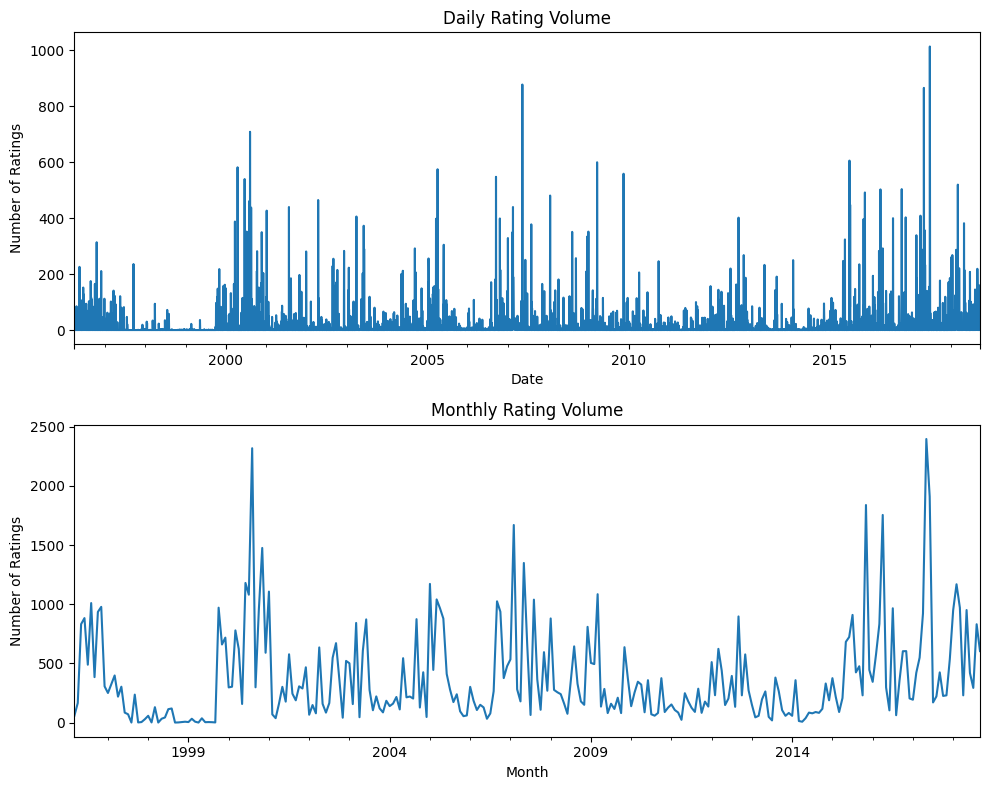

/var/folders/6l/dffvttrj3v35nxl93kxx60g40000gn/T/ipykernel_16867/4056393423.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  new_users  = first_user.set_index('first_rating').resample('M')['userId'].count()
/var/folders/6l/dffvttrj3v35nxl93kxx60g40000gn/T/ipykernel_16867/4056393423.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  new_movies = first_movie.set_index('first_rating').resample('M')['movieId'].count()


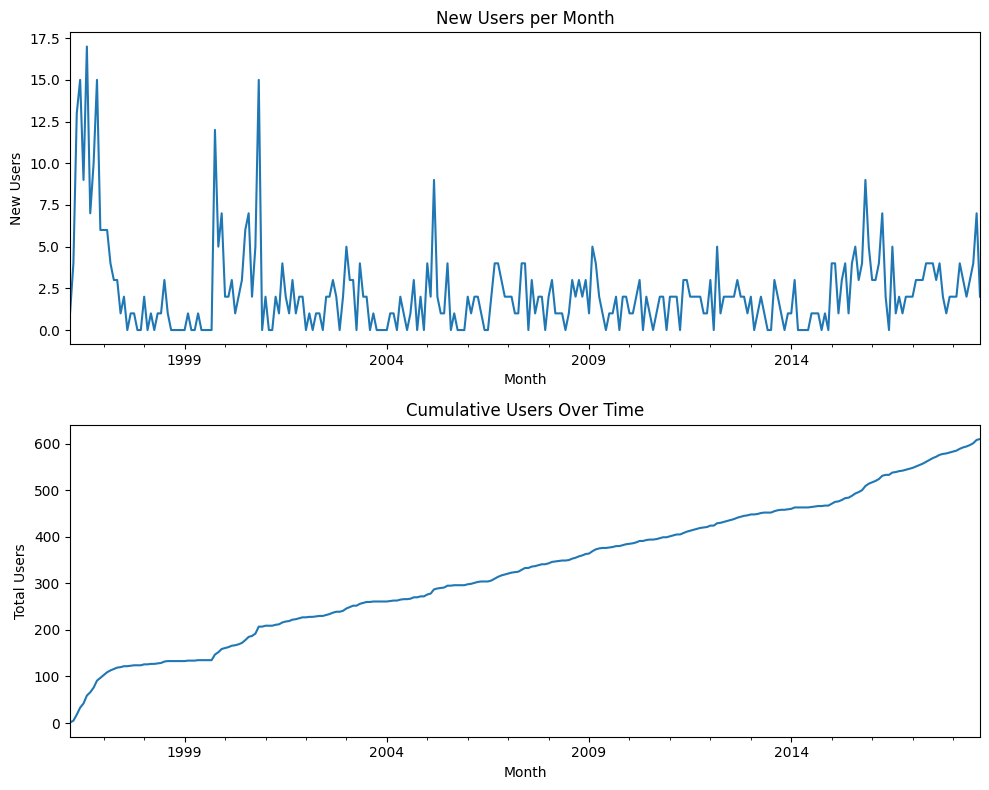

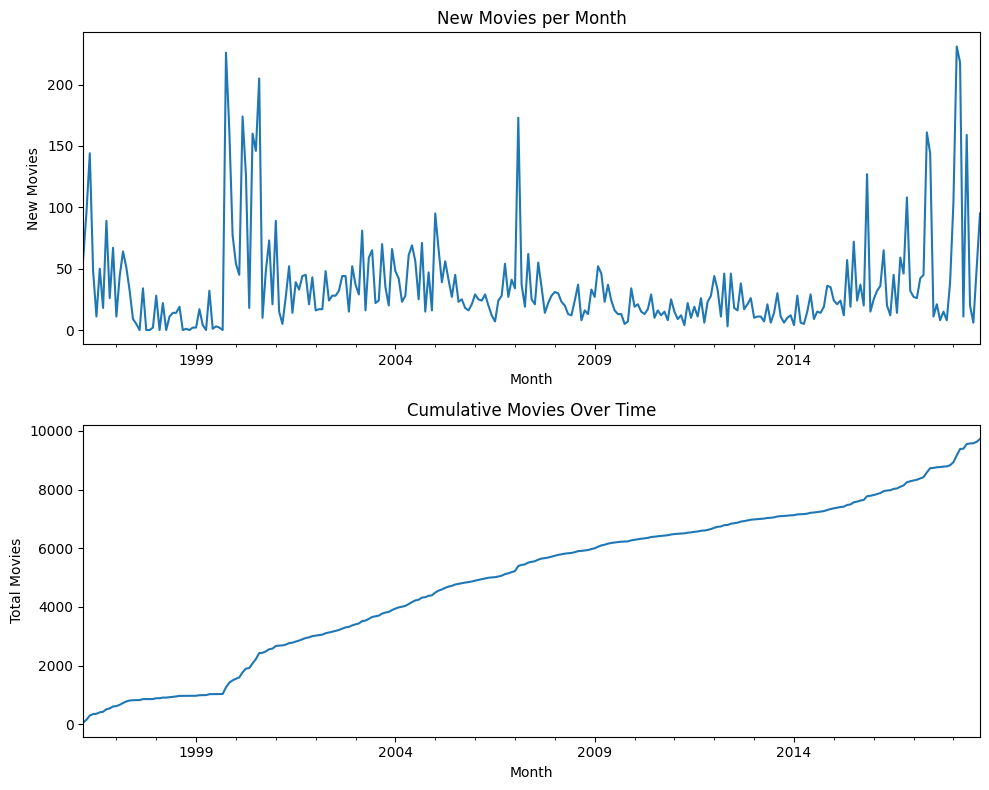

In [27]:

# 9.1 Ratings Over Time
daily_counts   = ratings.set_index('timestamp')['rating'].resample('D').count()
monthly_counts = ratings.set_index('timestamp')['rating'].resample('M').count()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
daily_counts.plot(ax=ax1)
ax1.set(title='Daily Rating Volume', xlabel='Date', ylabel='Number of Ratings')
monthly_counts.plot(ax=ax2)
ax2.set(title='Monthly Rating Volume', xlabel='Month', ylabel='Number of Ratings')
plt.tight_layout()
plt.show()

# 9.2 New Users & Movies Over Time
first_user  = ratings.groupby('userId')['timestamp'].min().reset_index(name='first_rating')
first_movie = ratings.groupby('movieId')['timestamp'].min().reset_index(name='first_rating')

new_users  = first_user.set_index('first_rating').resample('M')['userId'].count()
cum_users  = new_users.cumsum()
new_movies = first_movie.set_index('first_rating').resample('M')['movieId'].count()
cum_movies = new_movies.cumsum()

fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 8))
new_users.plot(ax=ax3)
ax3.set(title='New Users per Month', xlabel='Month', ylabel='New Users')
cum_users.plot(ax=ax4)
ax4.set(title='Cumulative Users Over Time', xlabel='Month', ylabel='Total Users')
plt.tight_layout()
plt.show()

fig, (ax5, ax6) = plt.subplots(2, 1, figsize=(10, 8))
new_movies.plot(ax=ax5)
ax5.set(title='New Movies per Month', xlabel='Month', ylabel='New Movies')
cum_movies.plot(ax=ax6)
ax6.set(title='Cumulative Movies Over Time', xlabel='Month', ylabel='Total Movies')
plt.tight_layout()
plt.show()

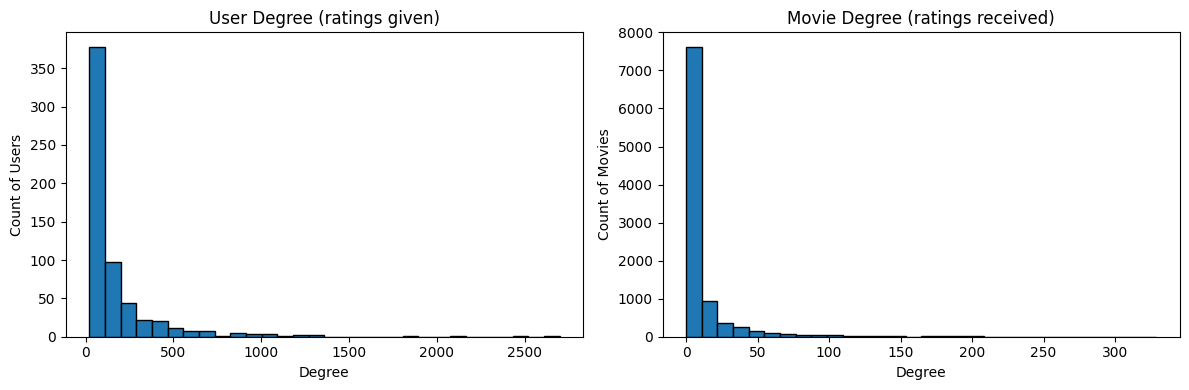

Connected components: 19
Largest component size: 10334 nodes


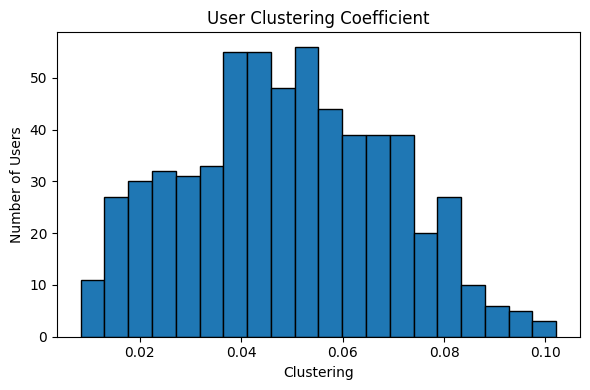

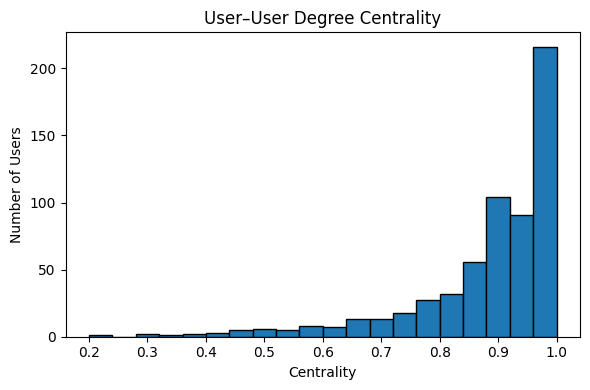

Average clustering in user‑user projection: 0.0090


In [31]:

# 10.0 Build the bipartite graph B
B = nx.Graph()
user_nodes  = [f"u{uid}" for uid in ratings['userId'].unique()]
movie_nodes = [f"m{mid}" for mid in movies['movieId'].unique()]
B.add_nodes_from(user_nodes,  bipartite=0)
B.add_nodes_from(movie_nodes, bipartite=1)
edges = [(f"u{r.userId}", f"m{r.movieId}") for r in ratings.itertuples()]
B.add_edges_from(edges)

# 10.1 Degree Distributions
user_degrees  = [B.degree(n) for n in user_nodes]
movie_degrees = [B.degree(n) for n in movie_nodes]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(user_degrees,  bins=30, edgecolor='k')
ax1.set(title='User Degree (ratings given)',    xlabel='Degree', ylabel='Count of Users')
ax2.hist(movie_degrees, bins=30, edgecolor='k')
ax2.set(title='Movie Degree (ratings received)', xlabel='Degree', ylabel='Count of Movies')
plt.tight_layout()
plt.show()

# 10.2 Connectivity & Components
num_cc     = nx.number_connected_components(B)
largest_cc = max(nx.connected_components(B), key=len)
print(f"Connected components: {num_cc}")
print(f"Largest component size: {len(largest_cc)} nodes")

# 10.3 Bipartite Clustering (for user set)
user_clust = bipartite.clustering(B, nodes=user_nodes)
fig, ax3 = plt.subplots(figsize=(6,4))
ax3.hist(list(user_clust.values()), bins=20, edgecolor='k')
ax3.set(title='User Clustering Coefficient', xlabel='Clustering', ylabel='Number of Users')
plt.tight_layout()
plt.show()

# 10.4 User‑User Projection Metrics
U           = bipartite.weighted_projected_graph(B, user_nodes)   # co‑rated movies as weights
avg_cluster = nx.average_clustering(U, weight='weight')
deg_cent    = nx.degree_centrality(U)

fig, ax4 = plt.subplots(figsize=(6,4))
ax4.hist(list(deg_cent.values()), bins=20, edgecolor='k')
ax4.set(title='User–User Degree Centrality', xlabel='Centrality', ylabel='Number of Users')
plt.tight_layout()
plt.show()
print(f"Average clustering in user‑user projection: {avg_cluster:.4f}")

In [32]:
# Assumes ratings is already loaded
k = 5  # threshold for "cold-start"

# Users: cold vs others
user_counts = ratings.groupby('userId').size()
cold_users  = user_counts[user_counts <= k].index
other_users = user_counts[user_counts >  k].index

cold_user_ratings  = ratings[ratings['userId'].isin(cold_users)]['rating']
other_user_ratings = ratings[ratings['userId'].isin(other_users)]['rating']

user_summary = pd.DataFrame({
    'group':      [f'≤ {k} ratings', f'> {k} ratings'],
    'num_users':  [len(cold_users), len(other_users)],
    'avg_rating': [cold_user_ratings.mean(), other_user_ratings.mean()]
})
print("=== User Cold‑Start vs. Others ===")
display(user_summary)

# Movies: cold vs others
movie_counts  = ratings.groupby('movieId').size()
cold_movies   = movie_counts[movie_counts <= k].index
other_movies  = movie_counts[movie_counts >  k].index

cold_movie_ratings  = ratings[ratings['movieId'].isin(cold_movies)]['rating']
other_movie_ratings = ratings[ratings['movieId'].isin(other_movies)]['rating']

movie_summary = pd.DataFrame({
    'group':      [f'≤ {k} ratings', f'> {k} ratings'],
    'num_movies': [len(cold_movies), len(other_movies)],
    'avg_rating': [cold_movie_ratings.mean(), other_movie_ratings.mean()]
})
print("\n=== Movie Cold‑Start vs. Others ===")
display(movie_summary)

=== User Cold‑Start vs. Others ===


,group,num_users,avg_rating
0,≤ 5 ratings,0,NaN
1,> 5 ratings,610,3.501557



=== Movie Cold‑Start vs. Others ===


,group,num_movies,avg_rating
0,≤ 5 ratings,6456,3.202173
1,> 5 ratings,3268,3.543813


Users rating every film the same: 1


,n_ratings,mean,rating_std
userId,,,
53,20,5.0,0.0



Movies with rating spikes (std ≥ 1.43): 316


,movieId,title,n_ratings,mean,rating_std
0,2068,Fanny and Alexander (Fanny och Alexander) (1982),2,2.75,3.181981
1,32892,Ivan's Childhood (a.k.a. My Name is Ivan) (Iva...,2,2.75,3.181981
2,3223,"Zed & Two Noughts, A (1985)",2,3.00,2.828427
3,84847,Emma (2009),2,2.50,2.828427
4,7564,Kwaidan (Kaidan) (1964),2,2.50,2.828427
5,484,Lassie (1994),2,3.00,2.828427
6,70946,Troll 2 (1990),3,3.50,2.598076
7,70687,Paper Heart (2009),2,2.75,2.474874
8,85885,Room in Rome (Habitación en Roma) (2010),2,2.75,2.474874
9,121097,To Grandmother's House We Go (1992),2,2.75,2.474874


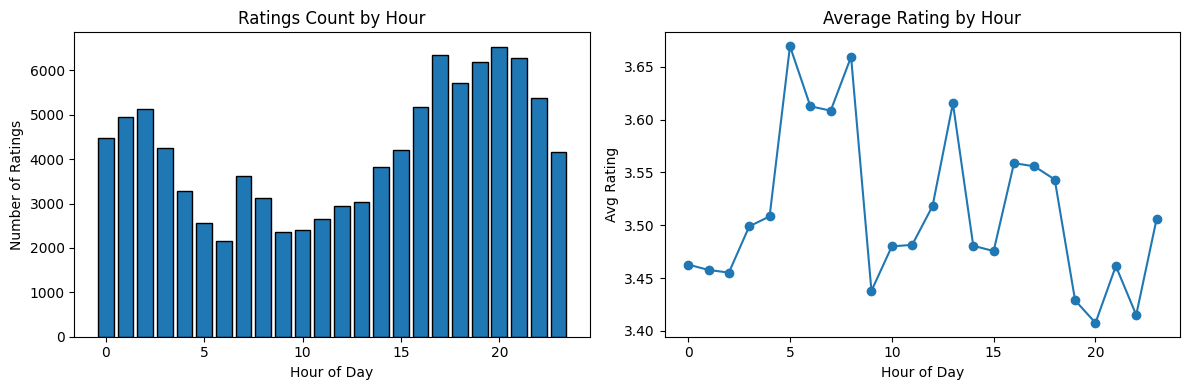

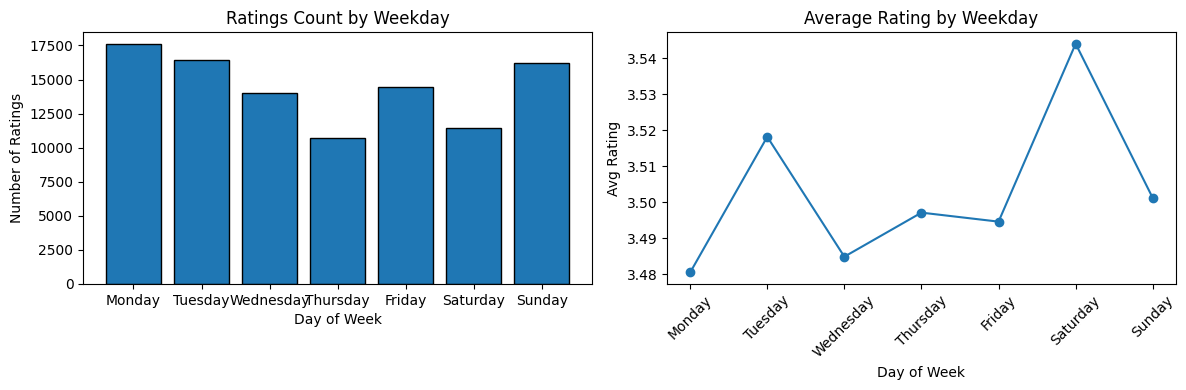

In [33]:
# 12.1 Users who rate every film the same
user_stats = ratings.groupby('userId')['rating'] \
                    .agg(['count','mean','std']) \
                    .rename(columns={'count':'n_ratings','std':'rating_std'})
same_rating_users = user_stats[user_stats['rating_std'] == 0]
print(f"Users rating every film the same: {len(same_rating_users)}")
display(same_rating_users.head())

# 12.2 Movies with rating spikes (high variance)
movie_stats = ratings.groupby('movieId')['rating'] \
                     .agg(['count','mean','std']) \
                     .rename(columns={'count':'n_ratings','std':'rating_std'})
# define spike threshold as top 5% of std
threshold = movie_stats['rating_std'].quantile(0.95)
spiky_movies = movie_stats[movie_stats['rating_std'] >= threshold] \
                .sort_values('rating_std', ascending=False)
# merge titles
spiky_movies = spiky_movies.merge(
    movies[['movieId','title']], on='movieId'
)[['movieId','title','n_ratings','mean','rating_std']]
print(f"\nMovies with rating spikes (std ≥ {threshold:.2f}): {len(spiky_movies)}")
display(spiky_movies.head(10))

# 12.3 Time‑of‑Day Effects
ratings['hour'] = ratings['timestamp'].dt.hour
hourly = ratings.groupby('hour')['rating'] \
                .agg(['count','mean']) \
                .reset_index()
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(hourly['hour'], hourly['count'], edgecolor='k')
ax[0].set(title='Ratings Count by Hour', xlabel='Hour of Day', ylabel='Number of Ratings')
ax[1].plot(hourly['hour'], hourly['mean'], marker='o')
ax[1].set(title='Average Rating by Hour', xlabel='Hour of Day', ylabel='Avg Rating')
plt.tight_layout()
plt.show()

# 12.4 Day‑of‑Week Effects
ratings['weekday'] = ratings['timestamp'].dt.day_name()
# ensure correct order
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday = ratings.groupby('weekday')['rating'] \
                 .agg(['count','mean']) \
                 .reindex(order) \
                 .reset_index()
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(weekday['weekday'], weekday['count'], edgecolor='k')
ax[0].set(title='Ratings Count by Weekday', xlabel='Day of Week', ylabel='Number of Ratings')
ax[1].plot(weekday['weekday'], weekday['mean'], marker='o')
ax[1].set(title='Average Rating by Weekday', xlabel='Day of Week', ylabel='Avg Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()